In [1]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_selection import RFE

In [2]:
data = np.genfromtxt("spambase.data", delimiter=',')
X = data[:,:-1]
#X = data[:,:48]
Y = data[:,-1]
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
print(X)

[[0.000e+00 6.400e-01 6.400e-01 ... 3.756e+00 6.100e+01 2.780e+02]
 [2.100e-01 2.800e-01 5.000e-01 ... 5.114e+00 1.010e+02 1.028e+03]
 [6.000e-02 0.000e+00 7.100e-01 ... 9.821e+00 4.850e+02 2.259e+03]
 ...
 [3.000e-01 0.000e+00 3.000e-01 ... 1.404e+00 6.000e+00 1.180e+02]
 [9.600e-01 0.000e+00 0.000e+00 ... 1.147e+00 5.000e+00 7.800e+01]
 [0.000e+00 0.000e+00 6.500e-01 ... 1.250e+00 5.000e+00 4.000e+01]]


In [3]:
Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=1)

In [4]:
print("Number of features:\t", X.shape[1])
print("Number of training data points:\t", Xtr.shape[0])
print("Number of test data points:\t", Xte.shape[0])

Number of features:	 57
Number of training data points:	 3220
Number of test data points:	 1381


In [5]:
print(X.shape)

(4601, 57)


## Feature Selection - RFE

In [24]:
def get_features (support):
    count = 0
    arr = []
    for i in support:
        if i:
            arr.append(count)
        count += 1
    return arr

In [26]:
cnt = 0
train_scores = list()
test_scores = list()
for i in range(1,X.shape[1]+1):
    logreg = LogisticRegression(tol=1e-8, C=0.1, random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000)
    selector = RFE(logreg, i).fit(X, Y)
    features = get_features(selector.support_)
    Xrfe = X[:,features]
    Xrfe_tr, Xrfe_te, Yrfe_tr, Yrfe_te = train_test_split(Xrfe, Y, test_size=0.3, shuffle=True, random_state=1)
    clf = logreg.fit(Xrfe_tr,Yrfe_tr)
    train_score = clf.score(Xrfe_tr,Yrfe_tr)
    test_score = clf.score(Xrfe_te,Yrfe_te)
    '''
    print("features:\t",i)
    print("training score:\t", train_score)
    print("test score:\t", test_score)
    '''
    train_scores.append(train_score)
    test_scores.append(test_score)

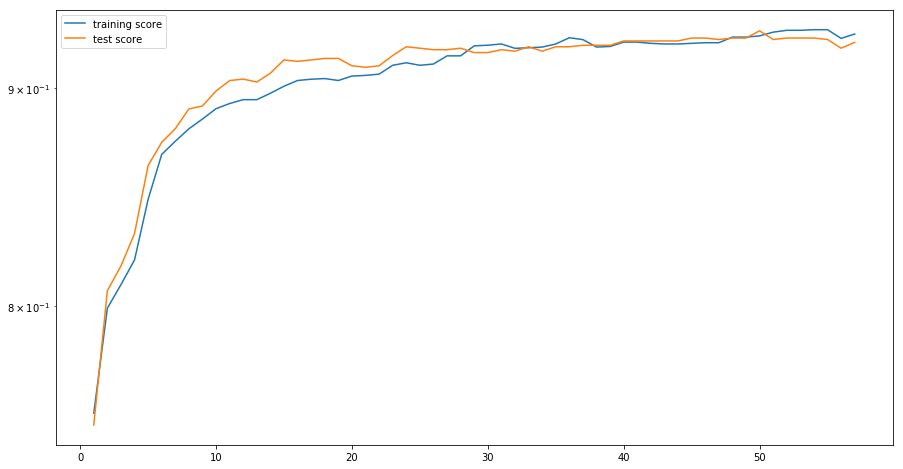

In [27]:
plt.rcParams["figure.figsize"] = (15.0,8.0)
plt.semilogy(range(1,X.shape[1]+1), train_scores, label="training score")
plt.semilogy(range(1,X.shape[1]+1), test_scores, label="test score")
plt.legend()
plt.show()

In [32]:
res = sorted(enumerate(test_scores), key=lambda d:d[1])[-1]
print("At feature =", res[0]," test score at highest at:", res[1])

At feature = 49  test score at highest at: 0.9283128167994207


## Data Training

In [8]:
#pca = PCA(n_components=30)
#Xpca = pca.fit_transform(X)
#print(Xpca)

In [9]:
logreg = LogisticRegression(tol=1e-8, C=0.1, random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000)
clf = logreg.fit(Xtr,Ytr)
#clf  = LogisticRegression(tol=1e-8, C=10.0).fit(Xtr, Ytr)

In [10]:
print("training score:\t", clf.score(Xtr,Ytr))
print("test score:\t", clf.score(Xte,Yte))

training score:	 0.9267080745341615
test score:	 0.9225199131064447


In [11]:
Yhat = clf.predict(Xte)

In [12]:
err = 0
for i in range(len(Xte)):
    if Yhat[i] != Yte[i]:
        err += 1
print("Error rate: ", err/len(Xte))

print("Ham Messages: ", len(np.where(Yte == 0)[0]))
print("Ham Prediction: ", len(np.where(Yhat == 0)[0]))
print("Spam Messages: ", len(np.where(Yte == 1)[0]))
print("Spam Prediction: ", len(np.where(Yhat == 1)[0]))

confusion_matrix(Yte, Yhat)

Error rate:  0.0774800868935554
Ham Messages:  841
Ham Prediction:  888
Spam Messages:  540
Spam Prediction:  493


array([[811,  30],
       [ 77, 463]])

## Changing Parameters

In [13]:
init = 10000
cval = []
train_error = []
test_error = []
for i in range(10):
    logreg = LogisticRegression(tol=1e-8, C=init, solver='lbfgs', multi_class='multinomial', max_iter=10000)
    clf = logreg.fit(Xtr,Ytr)
    train_error.append(1 - clf.score(Xtr,Ytr))
    test_error.append(1 - clf.score(Xte,Yte))
    cval.append(init)
    print("C=",init)
    print("training score:\t", clf.score(Xtr,Ytr))
    print("test score:\t", clf.score(Xte,Yte))
    init /= 10

C= 10000
training score:	 0.931055900621118
test score:	 0.9261404779145547
C= 1000.0
training score:	 0.9313664596273292
test score:	 0.9246922519913107
C= 100.0
training score:	 0.9304347826086956
test score:	 0.9254163649529327
C= 10.0
training score:	 0.931055900621118
test score:	 0.9275887038377987
C= 1.0
training score:	 0.9304347826086956
test score:	 0.9304851556842868
C= 0.1
training score:	 0.9267080745341615
test score:	 0.9225199131064447
C= 0.01
training score:	 0.9062111801242236
test score:	 0.9058653149891384
C= 0.001
training score:	 0.8611801242236025
test score:	 0.8624185372918175
C= 0.0001
training score:	 0.7562111801242236
test score:	 0.7530774800868936
C= 1e-05
training score:	 0.7391304347826086
test score:	 0.718320057929037


## Adding Polynomial Features

In [14]:
poly = PolynomialFeatures(2).fit(Xtr)
XtrP = poly.transform(Xtr)

#scaler = StandardScaler().fit(XtrP, Ytr)
#XtrP = scaler.transform(XtrP)

XteP = poly.transform(Xte)

lrP = LogisticRegression(tol=1e-10, C=100, random_state=0, solver='lbfgs', multi_class='multinomial')
clf = lrP.fit(XtrP,Ytr)

print("training score:\t", clf.score(XtrP,Ytr))
print("test score:\t", clf.score(XteP,Yte))

training score:	 0.6456521739130435
test score:	 0.6524257784214338


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
